## Resolved TKE budget

This notebook diagnoses the TKE budget for horizontally homogeneous turbulence from NCAR LES output:
$$\begin{equation*}
\frac{\partial e}{\partial t} =
\underbrace{
-\overline{u'w'}\frac{\partial \overline{u}}{\partial z}
-\overline{v'w'}\frac{\partial \overline{v}}{\partial z}
}_{P}
\underbrace{
-\overline{u'w'}\frac{\partial \overline{u}^S}{\partial z}
-\overline{v'w'}\frac{\partial \overline{v}^S}{\partial z}
}_{P^S}
+\underbrace{
\overline{w'b'}
}_{B}
\underbrace{
-\frac{\partial}{\partial z}\left(\frac{\overline{w'p'}}{\rho_0}+\overline{w'e}\right)
}_{T}
+D,
\end{equation*}$$
where $P$ is the shear production, $P^S$ is the Stokes production, $B$ is the buoyancy production, $T$ is the TKE transport and $D$ is the dissipation.

In [1]:
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
sys.path.append(os.environ['HOME']+'/work/lesview')
from lesview import *

In [2]:
# load data
casenames = ['MSM97-ST', 'MSM97-LT']
f_stokes = {'MSM97-ST':False, 'MSM97-LT':True}
ncarles_pfl = {}
ncarles_data_1d_pfl = 'his.mp.vis.000001.014401.nc'
for casename in casenames:
    ncarles_dir = os.environ['HOME']+'/scratch/benchmark/NCARLES/badger/ncarles/data/ncarles_'+casename
    ncarles_pfl[casename] = NCARLESDataProfile(filepath=ncarles_dir+'/'+ncarles_data_1d_pfl)

### Parameters 

In [3]:
# gravitational acceleration (m/s^2)
g = 9.81
# thermal expansion coefficient (1/degC)
alpha = 2.0e-4

In [4]:
# one inertial period (17 hours)
startdate = '2000-01-02T01:00:00'
enddate = '2000-01-02T18:00:00'

### Resolved TKE budget

All TKE budget terms are diagnosed at the interfaces of the vertical grid

In [5]:
def diag_TKE_budget(ds_pfl, startdate, enddate, stokes):
    # momentum fluxes
    uw_res = ds_pfl.dataset.data_vars['uwle'].sel(time=slice(startdate, enddate))[:-1,:]
    vw_res = ds_pfl.dataset.data_vars['vwle'].sel(time=slice(startdate, enddate))[:-1,:]
    uw_sgs = ds_pfl.dataset.data_vars['uwsb'].sel(time=slice(startdate, enddate))[:-1,:]
    vw_sgs = ds_pfl.dataset.data_vars['vwsb'].sel(time=slice(startdate, enddate))[:-1,:]
    # zi and time
    zi = uw_res.zi
    time = uw_res.time
    # shear, U and V are on z
    U = ds_pfl.dataset.data_vars['uxym'].sel(time=slice(startdate, enddate))
    V = ds_pfl.dataset.data_vars['vxym'].sel(time=slice(startdate, enddate))
    dUdz = xr.DataArray((U.diff('z')/U.z.diff('z')).values, dims=('zi', 'time'),
                        coords={'zi': zi, 'time': time},
                        attrs={'long_name': 'du/dz', 'units': '1/s'})
    dVdz = xr.DataArray((V.diff('z')/V.z.diff('z')).values, dims=('zi', 'time'),
                        coords={'zi': zi, 'time': time},
                        attrs={'long_name': 'dv/dz', 'units': '1/s'})

    # shear production
    Px = -uw_res*dUdz
    Py = -vw_res*dVdz
    P = Px + Py
    Px.attrs['long_name'] = 'resolved shear production, x-direction'
    Px.attrs['units'] = 'm$^2$/s$^3$'
    Py.attrs['long_name'] = 'resolved shear production, y-direction'
    Py.attrs['units'] = 'm$^2$/s$^3$'
    P.attrs['long_name'] = 'resolved shear production'
    P.attrs['units'] = 'm$^2$/s$^3$'
    Px_sgs = -uw_sgs*dUdz
    Py_sgs = -vw_sgs*dVdz
    P_sgs = Px_sgs + Py_sgs
    Px_sgs.attrs['long_name'] = 'subgrid-scale shear production, x-direction'
    Px_sgs.attrs['units'] = 'm$^2$/s$^3$'
    Py_sgs.attrs['long_name'] = 'subgrid-scale shear production, y-direction'
    Py_sgs.attrs['units'] = 'm$^2$/s$^3$'
    P_sgs.attrs['long_name'] = 'subgrid-scale shear production'
    P_sgs.attrs['units'] = 'm$^2$/s$^3$'

    # Stokes production
    if stokes:
        Us = ds_pfl.dataset.data_vars['stokes'].sel(time=slice(startdate, enddate))
        dUsdz = xr.DataArray((Us.diff('z')/Us.z.diff('z')).values, dims=('zi', 'time'),
                            coords={'zi': zi, 'time': time},
                            attrs={'long_name': 'dus/dz', 'units': '1/s'})
        PS = -uw_res*dUsdz
        PS_sgs = -uw_sgs*dUsdz
    else:
        PS = xr.zeros_like(P)
        PS_sgs = xr.zeros_like(P_sgs)
    PS.attrs['long_name'] = 'resolved Stokes production'
    PS.attrs['units'] = 'm$^2$/s$^3$'
    PS_sgs.attrs['long_name'] = 'subgrid-scale Stokes production'
    PS_sgs.attrs['units'] = 'm$^2$/s$^3$'

    # buoyancy production
    wt_res = ds_pfl.dataset.data_vars['wtle'].sel(time=slice(startdate, enddate))
    wt_sgs = ds_pfl.dataset.data_vars['wtsb'].sel(time=slice(startdate, enddate))
    B = g*alpha*wt_res
    B.attrs['long_name'] = 'resolved buoyancy production'
    B.attrs['units'] = 'm$^2$/s$^3$'
    B_sgs = g*alpha*wt_sgs
    B_sgs.attrs['long_name'] = 'subgrid-scale buoyancy production'
    B_sgs.attrs['units'] = 'm$^2$/s$^3$'

    # TEK transport
    Te = ds_pfl.dataset.data_vars['t_wq'].sel(time=slice(startdate, enddate))
    Tp = ds_pfl.dataset.data_vars['t_wp'].sel(time=slice(startdate, enddate))
    Tt = ds_pfl.dataset.data_vars['t_tau'].sel(time=slice(startdate, enddate))
    T = Te + Tp + Tt
    T.attrs['long_name'] = 'total TKE transport'
    T.attrs['units'] = 'm$^2$/s$^3$'

    # dissipation
    D = -ds_pfl.dataset.data_vars['t_dsle'].sel(time=slice(startdate, enddate))
    D.attrs['long_name'] = 'dissipation'
    D.attrs['units'] = 'm$^2$/s$^3$'

    # residual
    R = P+PS+B+T+D
    
    return {'P':P, 'PS':PS, 'B':B, 'T':T, 'D':D, 'R':R}

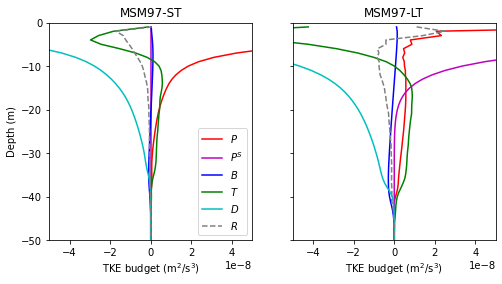

In [6]:
depth = -50
fig, axarr = plt.subplots(1, 2, sharey='row')
fig.set_size_inches([8,4])
for i, casename in enumerate(casenames):
    ds_pfl = ncarles_pfl[casename]
    stokes = f_stokes[casename]
    budget = diag_TKE_budget(ds_pfl, startdate, enddate, stokes)
    budget['P'].mean('time').plot(y='zi', ax=axarr[i], color='r', label='$P$')
    budget['PS'].mean('time').plot(y='zi', ax=axarr[i], color='m', label='$P^S$')
    budget['B'].mean('time').plot(y='zi', ax=axarr[i], color='b', label='$B$')
    budget['T'].mean('time').plot(y='zi', ax=axarr[i], color='g', label='$T$')
    budget['D'].mean('time').plot(y='zi', ax=axarr[i], color='c', label='$D$')
    budget['R'].mean('time').plot(y='zi', ax=axarr[i], color='gray', linestyle='--', label='$R$')
    axarr[i].set_xlim([-0.5e-7, 0.5e-7])
    axarr[i].set_xlabel('TKE budget (m$^2$/s$^3$)')
    axarr[i].set_ylim([depth, 0])
    axarr[i].set_title(casename)
axarr[0].set_ylabel('Depth (m)')
axarr[1].set_ylabel('')
axarr[0].legend(loc='lower right')